In [1]:
%load_ext cython
import pyrost as rst
# import speckle_tracking as st
import pyfftw
from pyrost.bin import *
from pyrost import simulation as st_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from multiprocessing import cpu_count
from importlib import reload

pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport.pyximport.PyxImporter at 0x7f874057d5d0>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'bar_positions', 'barcode_profile', 'fft_convolve', 'fraunhofer_wp', 'gaussian_filter', 'gaussian_gradient_magnitude', 'gaussian_kernel', 'gf', 'ggm', 'init_fftw', 'make_frames', 'make_whitefield', 'mll_profile', 'next_fast_len', 'np', 'rsc_wp']


In [3]:
from scipy.ndimage import gaussian_gradient_magnitude as ggm_scipy

size = 1000
sigma = float(size / 10)

img = np.random.random((size, size))
# %time img_dev = gaussian_gradient_magnitude(img, sigma, backend='numpy', num_threads=1)
# %time img_sp = ggm_scipy(img, sigma)
# %time img_sp = gaussian_gradient_magnitude(img, sigma, backend='fftw', num_threads=1)
%time img_dev = gaussian_filter(img, sigma, backend='numpy', num_threads=1)
%time img_sp = gaussian_filter(img, sigma, backend='fftw', num_threads=1)
%time img_dev = gaussian_filter(img, sigma, backend='numpy', num_threads=12)
%time img_sp = gaussian_filter(img, sigma, backend='fftw', num_threads=12)

CPU times: user 54.4 ms, sys: 3.22 ms, total: 57.6 ms
Wall time: 57.7 ms
CPU times: user 64.9 ms, sys: 3.65 ms, total: 68.5 ms
Wall time: 68.5 ms
CPU times: user 116 ms, sys: 8.19 ms, total: 124 ms
Wall time: 26.1 ms
CPU times: user 6.4 s, sys: 657 ms, total: 7.06 s
Wall time: 910 ms


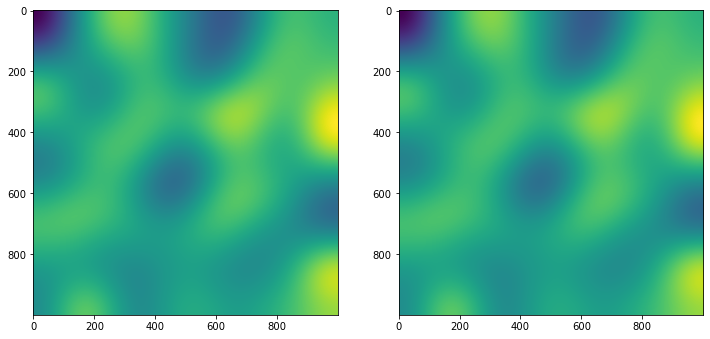

In [4]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_dev)
axes[1].imshow(img_sp)
plt.show()

# ST Simulation

In [5]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, p0 = 5e4, th_s=8e-5, n_frames=200,
                           offset=2.0, step_size=0.1, focus=1500, defocus=500,
                           alpha=0.05, ab_cnt=0.7, bar_rnd=0.7, ap_x=40, ap_y=10, det_dist=1.5e6,
                           fs_size=2000, ss_size=2000)

globals().update(**params.export_dict())
print(params)

{'defocus': 500.0, 'det_dist': 1500000.0, 'n_frames': 200, 'step_size': 0.1, 'step_rnd': 0.2, 'fs_size': 2000, 'pix_size': 55.0, '...': '...'}


In [6]:
n_x = params.x_wavefront_size()
n_y = params.y_wavefront_size()
nx_arr = np.arange(-n_x // 2, n_x // 2)
ny_arr = np.arange(-n_y // 2, n_y // 2)
lens_wfx, lens_wfy, dx0, dy0 = params.lens_wavefronts(return_dxdy=True)
print(n_x, n_y)

58527 20118


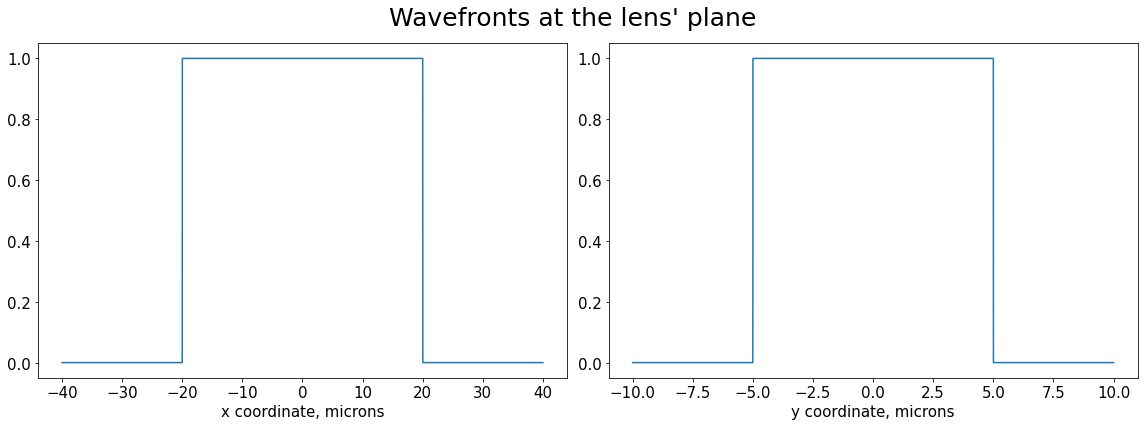

In [7]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx0 * nx_arr, np.abs(lens_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy0 * ny_arr, np.abs(lens_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the lens' plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/lens_wf.pdf')

In [12]:
dx1, dy1 = dx0 * defocus / focus, dy0
z01 = focus + defocus
lens_ext = np.tile(lens_wfx[None, :], (10, 1))
krn = dev.gaussian_kernel(50.)
print(lens_ext.shape)


# defoc_wfx = dev.fft_convolve(lens_ext.real, krn, axis=0, num_threads=1, backend='numpy')

%time defoc_wfx = rsc_wp(lens_ext, dx0, dx1, z01, wl, backend='fftw', axis=1, num_threads=1)
%time defoc_wfx = rsc_wp(lens_ext, dx0, dx1, z01, wl, backend='fftw', axis=1, num_threads=12)
# %time defoc_wfx = dev.rsc_wp(lens_ext, dx0, dx1, z01, wl, backend='numpy', axis=0, num_threads=1)
# %time defoc_wfx = dev.rsc_wp(lens_ext, dx0, dx1, z01, wl, backend='numpy', axis=0, num_threads=12)

(10, 58527)
CPU times: user 177 ms, sys: 2.65 ms, total: 180 ms
Wall time: 179 ms
CPU times: user 395 ms, sys: 16.6 ms, total: 412 ms
Wall time: 42.8 ms


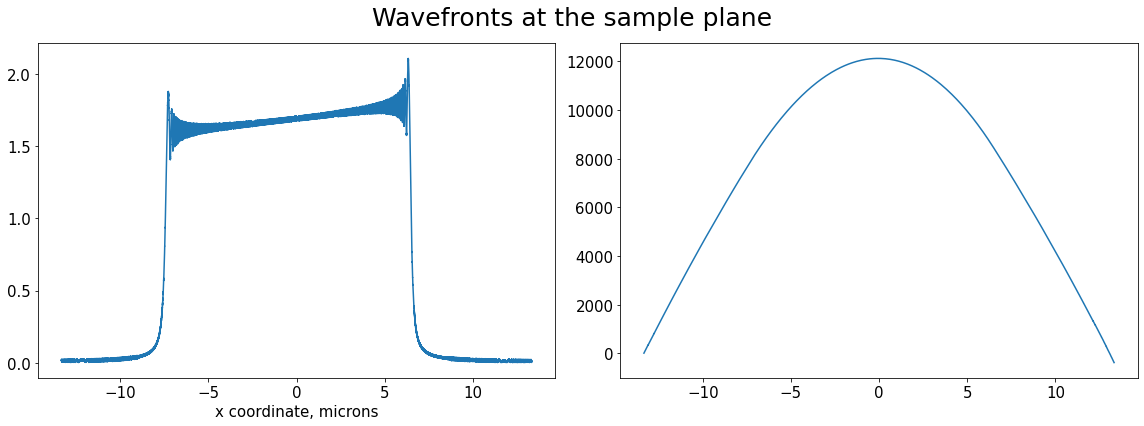

In [13]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx1 * nx_arr, np.abs(defoc_wfx[0]))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dx1 * nx_arr, np.unwrap(np.angle(defoc_wfx[0])))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the sample plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/sample_wf.pdf')

In [14]:
dx1, dy1 = dx0 * defocus / focus, dy0
z01 = focus + defocus
defoc_wfx = rsc_wp(lens_wfx, dx0, dx1, z01, wl, backend='fftw', num_threads=1)
defoc_wfy = rsc_wp(lens_wfy, dy0, dy1, z01, wl, backend='fftw', num_threads=1)

In [15]:
x0, x1 = params.beam_span(defocus)
x1 += step_size * n_frames
bar_pos = bar_positions(x0 + offset, x1 - offset, bar_size, bar_rnd, 0)

In [16]:
smp_pos = params.sample_positions()
x_arr = dx1 * nx_arr + smp_pos[:, None]
%time b_tr = barcode_profile(x_arr, bar_pos, 0.3, 0.1, params.bar_sigma, 12)
smp_wfx = defoc_wfx * b_tr

CPU times: user 2.16 s, sys: 96.9 ms, total: 2.26 s
Wall time: 243 ms


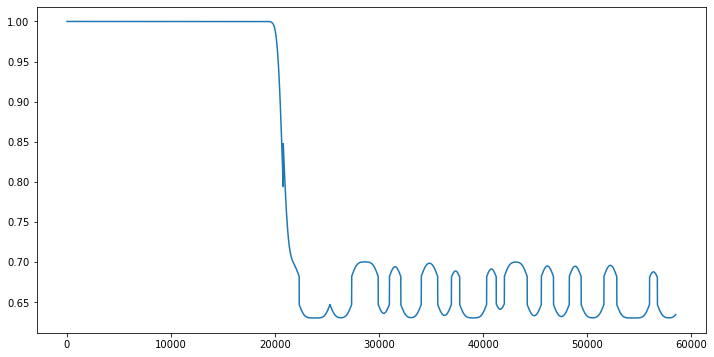

In [17]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.abs(b_tr[0]))
plt.show()

In [18]:
dx2, dy2 = fs_size * pix_size / n_x, ss_size * pix_size / n_y
%time det_wfx = fraunhofer_wp(smp_wfx, dx1, dx2, det_dist, wl, backend='fftw', num_threads=12)
%time det_wfy = fraunhofer_wp(defoc_wfy, dy1, dy2, det_dist, wl, num_threads=12)
print(smp_wfx.shape, det_wfx.shape)

CPU times: user 5.03 s, sys: 281 ms, total: 5.31 s
Wall time: 587 ms
CPU times: user 89.7 ms, sys: 2.31 ms, total: 92 ms
Wall time: 7.73 ms
(200, 58527) (200, 58527)


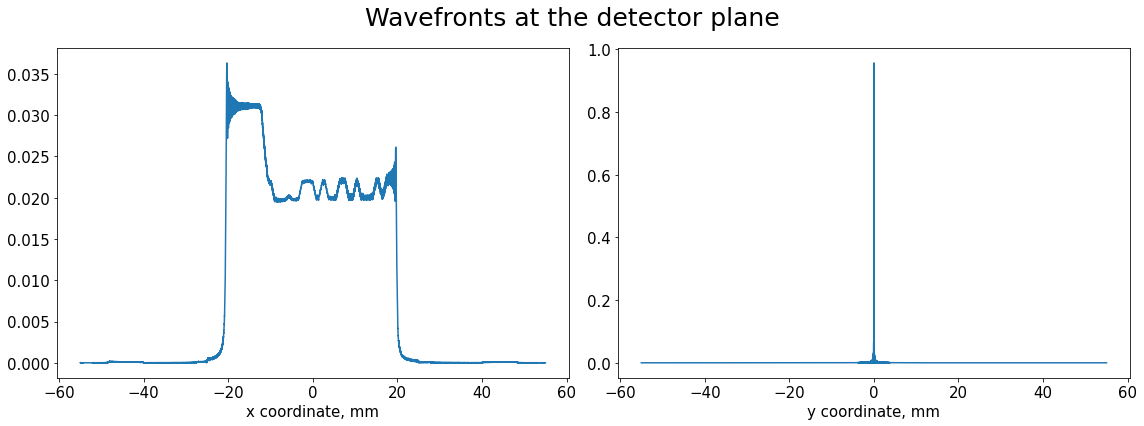

In [19]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.abs(det_wfx[2]))
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.abs(det_wfy))
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_wf.pdf')

In [25]:
sc_x = params.source_curve(defocus + det_dist, dx2)
sc_y = params.source_curve(defocus + det_dist, dy2)
pfx = np.sqrt(p0) / ap_x * np.abs(det_wfx)**2
pfy = np.sqrt(p0) / ap_y * np.abs(det_wfy)**2
print(pfx.shape, sc_x.shape)
%time det_ix = fft_convolve(pfx, sc_x, backend='numpy', axis=1)
%time det_iy = fft_convolve(pfy, sc_y, backend='numpy')
# print(det_ix.shape, det_iy.shape)

(200, 58527) (511,)
CPU times: user 282 ms, sys: 12.2 ms, total: 294 ms
Wall time: 294 ms
CPU times: user 1.2 ms, sys: 75 µs, total: 1.28 ms
Wall time: 937 µs


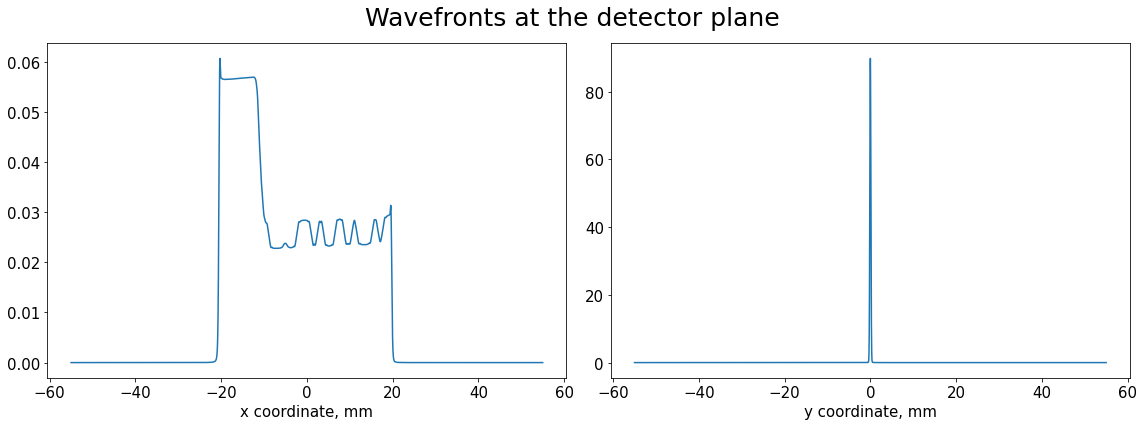

In [26]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.sqrt(p0) / ap_x * det_ix[0] * dx2)
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.sqrt(p0) / ap_y * det_iy * dy2)
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_int.pdf')

In [32]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'bar_positions', 'barcode_profile', 'fft_convolve', 'fraunhofer_wp', 'gaussian_filter', 'gaussian_gradient_magnitude', 'gaussian_kernel', 'gf', 'ggm', 'init_fftw', 'make_frames', 'make_whitefield', 'mll_profile', 'next_fast_len', 'np', 'rsc_wp']


In [34]:
wfx = np.ones(fs_size)
wfy = np.ones(ss_size)
# %time frames = make_frames(det_ix, det_iy, wfx, wfy, dx2, dy2, -1, 1)
%time wfield = dev.make_whitefield(frames, np.ones(frames.shape, dtype=bool), 0, 12)
frames.shape, wfield.shape

CPU times: user 17.8 s, sys: 263 ms, total: 18 s
Wall time: 1.86 s


((200, 2000, 2000), (2000, 2000))

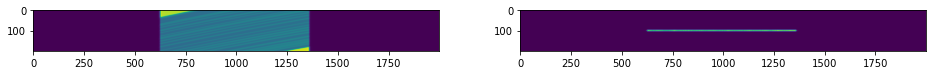

In [35]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(frames.sum(axis=1))
axes[1].imshow(wfield[(ss_size // 2 - 100):(ss_size // 2 + 100), :])
plt.show()

In [19]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

In [20]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [3]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.18,
                           bulk_atn=0.15, rnd_dev=0.7, p0=5e4, th_s=1.5e-4,
                           n_frames=200, defocus=40, alpha=0.04, ab_cnt=0.7,
                           step_size=0.15, step_rnd=0.8, seed=8457259)
st_conv = st_sim.converter()
sim_obj = st_sim.STSim(params)
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

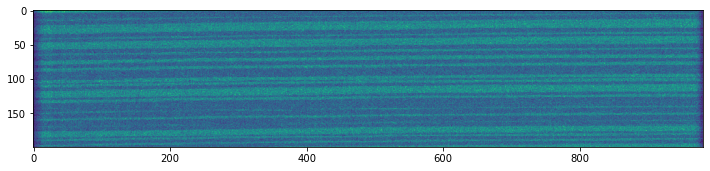

In [4]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

In [3]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'init_fftw', 'make_reference', 'np']


In [4]:
params = st_sim.parameters(bar_size=0.25, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, bar_rnd=0.7, p0 = 5e4, th_s=8e-5,
                           n_frames=200, defocus=30, alpha=0.03,
                           ab_cnt=0.7)

bar_pos = params.bar_positions(params.focus + params.defocus)
st_conv = st_sim.converter()

In [5]:
sim_obj = st_sim.STSim(params=params, bar_pos=bar_pos)
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

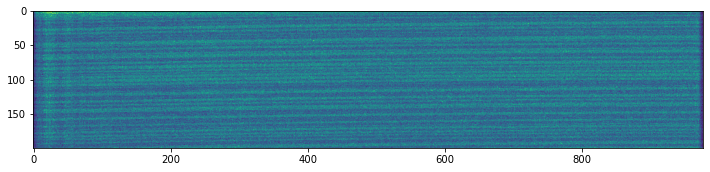

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

In [10]:
sw_fs=10
sw_ss=0
ls_ri=8.
ls_pm=2.5
blur=6
n_iter=30
f_tol=1e-6
momentum=0.
learning_rate=1e1
gstep=.1

st_obj = data.get_st(num_threads=1)

velocity = 0.0
obj = st_obj.update_reference(ls_ri=ls_ri)
obj.update_errors.inplace_update()
extra = {'errors': [obj.error_frame.mean()],
         'lss_ri': [ls_ri]}
print('Initial MSE = {:.6f}, Initial ls_ri = {:.2f}'.format(extra['errors'][-1],
                                                            extra['lss_ri'][-1]))
for it in range(1, n_iter + 1):
    # Update pixel_map
    new_obj = obj.update_pixel_map(ls_pm=ls_pm, sw_fs=sw_fs, sw_ss=sw_ss)
    obj.pixel_map += gaussian_filter(new_obj.pixel_map - obj.pixel_map,
                                     (0, blur, blur), mode='nearest',
                                     num_threads=st_obj.num_threads)

    # Update ls_ri
    grad = (obj.mse_total(ls_ri + gstep) - extra['errors'][-1]) / gstep
    velocity = np.clip(momentum * velocity - learning_rate * grad,
                       -0.75 * ls_ri, 0.75 * ls_ri)
    ls_ri += velocity
    extra['lss_ri'].append(ls_ri)

    # Update reference_image
    obj.update_reference.inplace_update(ls_ri=ls_ri)
    obj.update_errors.inplace_update()
    extra['errors'].append(obj.error_frame.mean())
    print('Iteration No. {:d}: Total MSE = {:.6f}, ls_ri = {:.2f}'.format(it, extra['errors'][-1],
                                                                          extra['lss_ri'][-1]))

Initial MSE = 0.387328, Initial ls_ri = 8.00
Iteration No. 1: Total MSE = 0.346369, ls_ri = 10.98
Iteration No. 2: Total MSE = 0.306563, ls_ri = 14.24
Iteration No. 3: Total MSE = 0.272494, ls_ri = 17.10
Iteration No. 4: Total MSE = 0.243083, ls_ri = 19.70
Iteration No. 5: Total MSE = 0.219145, ls_ri = 21.93
Iteration No. 6: Total MSE = 0.200405, ls_ri = 23.75
Iteration No. 7: Total MSE = 0.186550, ls_ri = 25.04
Iteration No. 8: Total MSE = 0.175859, ls_ri = 26.04
Iteration No. 9: Total MSE = 0.166880, ls_ri = 26.91
Iteration No. 10: Total MSE = 0.156985, ls_ri = 27.86
Iteration No. 11: Total MSE = 0.145928, ls_ri = 28.89
Iteration No. 12: Total MSE = 0.133543, ls_ri = 30.02
Iteration No. 13: Total MSE = 0.122491, ls_ri = 31.04
Iteration No. 14: Total MSE = 0.110883, ls_ri = 32.13
Iteration No. 15: Total MSE = 0.099290, ls_ri = 33.23
Iteration No. 16: Total MSE = 0.088948, ls_ri = 34.20
Iteration No. 17: Total MSE = 0.081227, ls_ri = 34.94
Iteration No. 18: Total MSE = 0.075585, ls_ri 

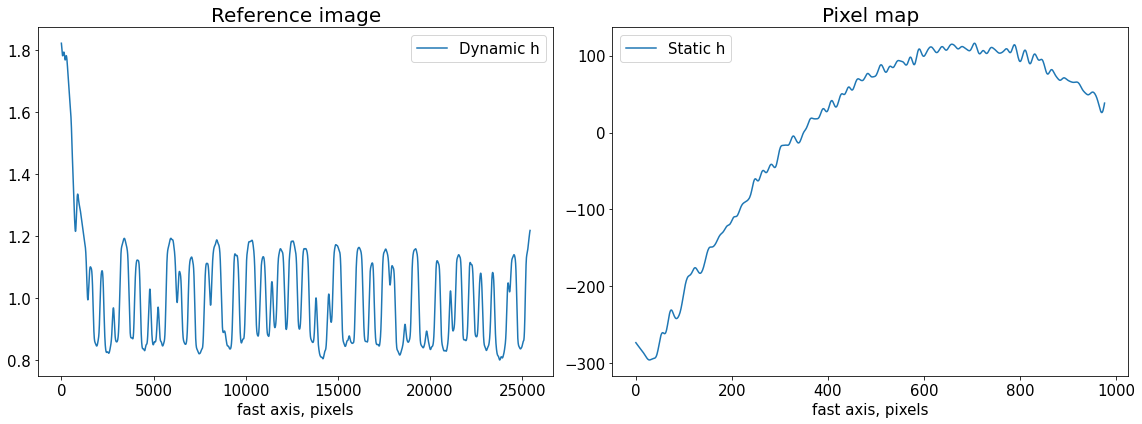

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(obj.reference_image[0], label='Dynamic h')
axes[1].plot((obj.pixel_map - st_obj.pixel_map)[1, 0] - 
             (obj.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel map', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('fast axis, pixels', fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
st_obj = data.get_st(num_threads=1)
st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=8., ls_pm=2.5, blur=6, verbose=True, n_iter=30)

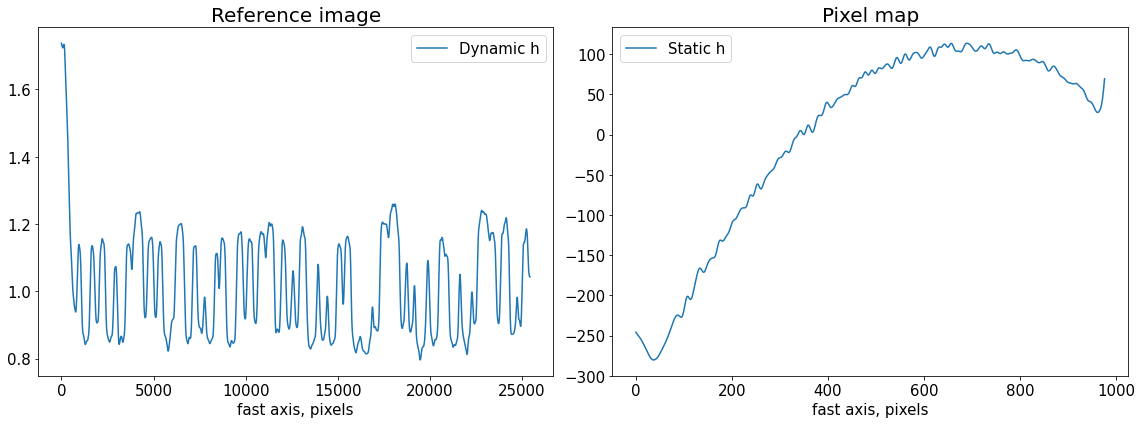

In [26]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0], label='Dynamic h')
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0] - 
             (st_res.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel map', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('fast axis, pixels', fontsize=15)
plt.tight_layout()
plt.show()

In [27]:
data = data.update_phase(st_res)
fit_obj = data.get_fit()
fit_obj.defocus = np.abs(fit_obj.defocus)
fit = fit_obj.fit()
ph_fit = fit_obj.fit_phase()

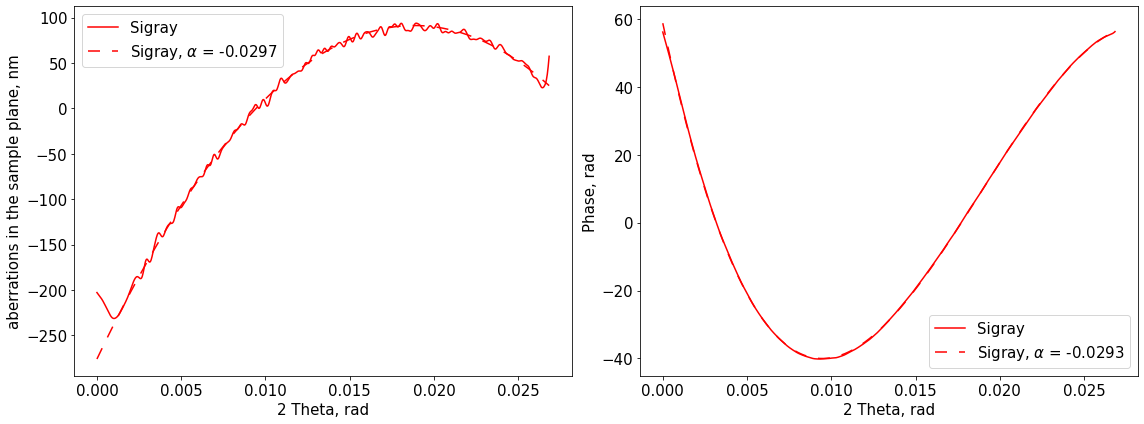

In [28]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.pixel_aberrations * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label='Sigray', c='r')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.model(fit['fit']) * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[0].set_ylabel('aberrations in the sample plane, nm', fontsize=15)
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.phase, label='Sigray', c='r')
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap, fit_obj.model(ph_fit['ph_fit']), 
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(ph_fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[1].set_ylabel('Phase, rad', fontsize=15)
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [10]:
loader = rst.loader()
data = loader.load('results/exp/diatom.cxi', roi=(70, 420, 50, 455), good_frames=np.arange(1, 121))
data = data.update_mask(method='perc-bad', pmin=0.05, pmax=99.998)

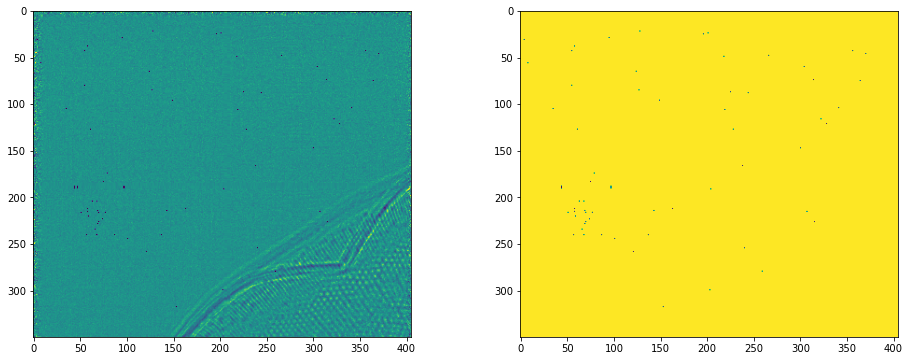

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(np.where(data.get('mask')[0],
                        data.get('data')[0] / data.get('whitefield'),
                        0), vmin=0.5, vmax=1.5)
axes[1].imshow(data.get('mask')[0], vmin=0, vmax=1)
plt.show()

In [12]:
st_obj = data.get_st()
st_obj = st_obj.update_reference(ls_ri=1.1, sw_ss=0, sw_fs=0)

In [14]:
st_obj = data.get_st()
st_rgd = st_obj.iter_update_gd(ls_ri=1.1, ls_pm=1.5, sw_fs=2, sw_ss=2, n_iter=4,
                               verbose=True, learning_rate=0.1)

Initial MSE = 0.874955, Initial ls_ri = 1.10
Iteration No. 1: Total MSE = 0.662130, ls_ri = 1.30
Iteration No. 2: Total MSE = 0.487592, ls_ri = 1.47
Iteration No. 3: Total MSE = 0.446233, ls_ri = 1.52
Iteration No. 4: Total MSE = 0.429475, ls_ri = 1.55


In [16]:
data.data.shape, data.mask.shape

((121, 516, 1556), (121, 516, 1556))

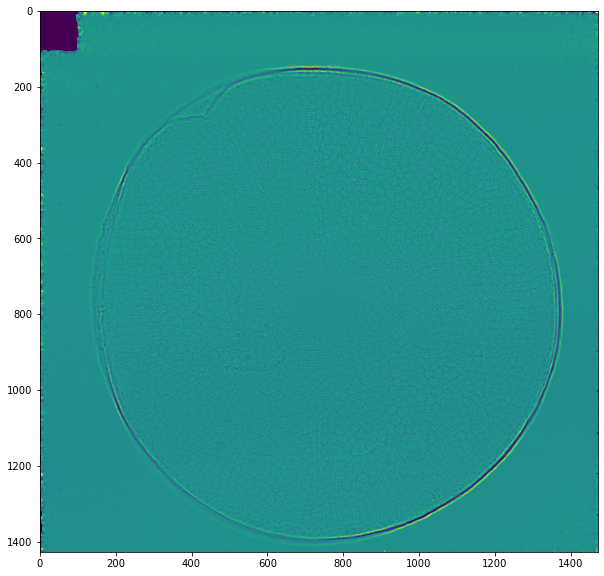

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(st_obj.reference_image, vmin=0.7, vmax=1.3)
ax.imshow(st_rgd.reference_image, vmin=0.7, vmax=1.3)
plt.show()

# Datasets simulation

In [125]:
st_conv = st_sim.converter()
n_frames_arr = np.unique(np.geomspace(2, 500, 30).astype(int))
p0_tot = 5e6

params = st_sim.parameters(bar_size=0.5, bar_sigma=0.12, bar_atn=0.15,
                           bulk_atn=0.15, bar_rnd=0.9, th_s=2.5e-4, n_frames=n_frames_arr.max(),
                           defocus=80, offset=0.0, alpha=0.03, ab_cnt=0.7, step_size=0.25)
param_dict, sim_dict, data_dict = {}, {}, {}

envelope = np.exp(-(np.arange(params.fs_size) - 0.3 * params.fs_size)**2 / (0.15 * params.fs_size**2))
envelope = gaussian_filter(envelope + 0.7 * (np.random.random(envelope.shape) - 0.5), envelope.size / 80)
bar_pos = params.bar_positions(params.defocus)

ls_ri = 8
ls_pm = 6
sw_fs = 8

for n_frames in n_frames_arr:
    key = n_frames
    params = st_sim.parameters(**params.export_dict())
    params.n_frames = n_frames
    params.p0 = p0_tot / n_frames
    param_dict[key] = params
    sim_dict[key] = st_sim.STSim(params=params, bar_pos=bar_pos)
    ptych = sim_dict[key].ptychograph(wfield_x=envelope)
    data_dict[key] = st_conv.export_data(ptych, sim_dict[key])
    
    st_obj = data_dict[key].get_st()
    st_res = st_obj.iter_update_gd(sw_fs=sw_fs, ls_ri=ls_ri, ls_pm=ls_pm)
    data_dict[key] = data_dict[key].update_phase(st_res)
    
print([(key, data.fit_phase()['alpha']) for key, data in data_dict.items()])
print(np.mean([data.fit_phase()['alpha'] + params.alpha for data in data_dict.values()]))

[(2, -0.0010970531742568203), (3, -0.005452045253402129), (4, -0.022519016741714998), (5, -0.01761716126933869), (6, -0.017648204181528043), (7, -0.013029442537691999), (9, -0.02053336177403712), (11, -0.038367140880125744), (13, -0.03631703326132424), (16, -0.02662191039381513), (19, -0.031452732805252695), (23, -0.03039090192535564), (28, -0.033218819730199356), (34, -0.030934019238017186), (42, -0.029004408896716), (50, -0.030094216017019455), (61, -0.027377729039507113), (74, -0.027907084024714802), (90, -0.029230002969967802), (109, -0.027013507928189694), (131, -0.03002357605344061), (159, -0.029386753728969765), (192, -0.028050755277858604), (233, -0.0292632574293093), (282, -0.02634529180399038), (341, -0.024598575909185873), (413, -0.025877962156350662), (500, -0.026863968634878208)]
0.00442014524870864


In [137]:
dir_path = 'results/power_tot/n_frames_{:d}'
for key in data_dict:
    print(dir_path.format(param_dict[key].n_frames))
    st_conv.save_sim(sim_dict[key].ptychograph(wfield_x=envelope), sim_dict[key], dir_path.format(param_dict[key].n_frames))
    with h5py.File(os.path.join(dir_path.format(param_dict[key].n_frames), 'data.cxi'), 'r+') as cxi_file:
        data_dict[key].write_cxi(cxi_file, overwrite=True)

results/power_tot/n_frames_2
results/power_tot/n_frames_3
results/power_tot/n_frames_4
results/power_tot/n_frames_5
results/power_tot/n_frames_6
results/power_tot/n_frames_7
results/power_tot/n_frames_9
results/power_tot/n_frames_11
results/power_tot/n_frames_13
results/power_tot/n_frames_16
results/power_tot/n_frames_19
results/power_tot/n_frames_23
results/power_tot/n_frames_28
results/power_tot/n_frames_34
results/power_tot/n_frames_42
results/power_tot/n_frames_50
results/power_tot/n_frames_61
results/power_tot/n_frames_74
results/power_tot/n_frames_90
results/power_tot/n_frames_109
results/power_tot/n_frames_131
results/power_tot/n_frames_159
results/power_tot/n_frames_192
results/power_tot/n_frames_233
results/power_tot/n_frames_282
results/power_tot/n_frames_341
results/power_tot/n_frames_413
results/power_tot/n_frames_500


In [138]:
# %%capture
loader = rst.loader(policy={'phase': True, 'pixel_aberrations': True,
                            'error_frame': True, 'reference_image': True})
param_dict, data_dict = {}, {}
for dir_path in ['results/power_tot']:
    for scan_dir in os.listdir(dir_path):
        scan_dir = os.path.join(dir_path, scan_dir)
        if os.path.isdir(scan_dir):
            params = st_sim.STParams.import_ini(os.path.join(scan_dir, 'parameters.ini'))
            key = params.n_frames
            param_dict[key] = params
            data = loader.load(os.path.join(scan_dir, 'data.cxi'))
            data_dict[key] = data

In [139]:
key = 6
data = data_dict[key]

In [140]:
data.data.sum()

4383248.0

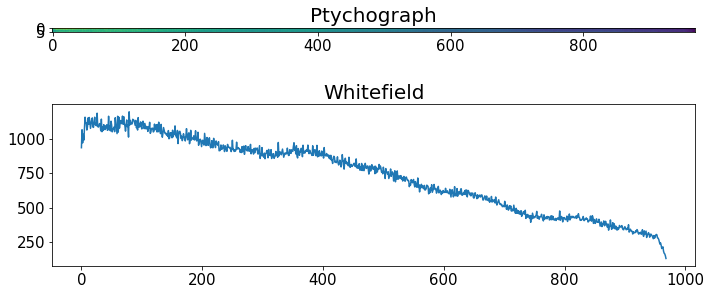

In [141]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].imshow(data.get('data')[:, 0])
axes[0].set_title('Ptychograph', fontsize=20)
axes[1].plot(data.get('whitefield')[0])
axes[1].set_title('Whitefield', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
# plt.savefig('../figures/ptycho_sim.pdf')
plt.show()

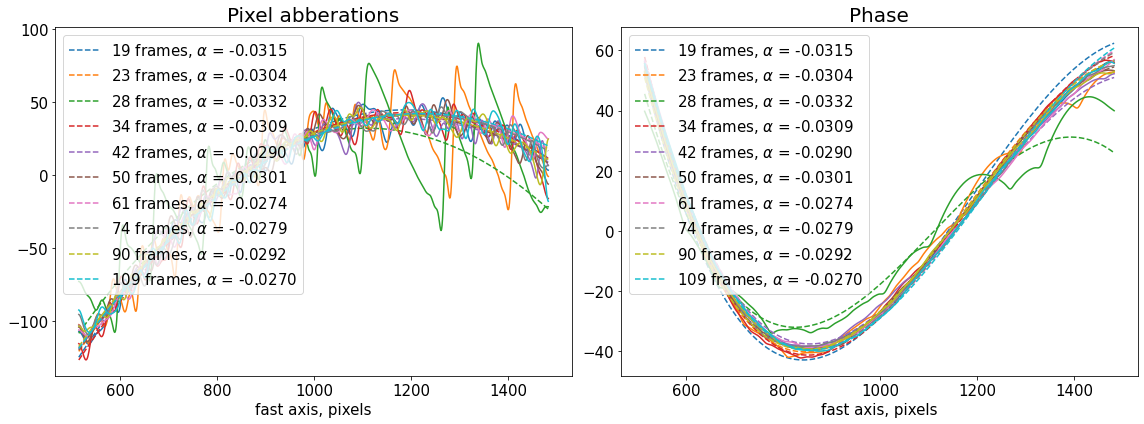

In [142]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for key, color in zip(sorted(data_dict)[10:], mcolors.TABLEAU_COLORS.values()):
    fit_obj = data_dict[key].get_fit()
    fit = fit_obj.fit()
    axes[0].plot(fit_obj.pixels, fit_obj.pixel_aberrations, color=color)
    axes[0].plot(fit_obj.pixels, fit_obj.model(fit['fit']), color=color, linestyle='dashed',
                 label='{:d} frames, '.format(key) + r'$\alpha$ = ' + '{:.4f}'.format(fit['alpha']))
    axes[0].set_title('Pixel aberrations', fontsize=20)
    axes[1].plot(fit_obj.pixels, fit_obj.phase, color=color)
    axes[1].plot(fit_obj.pixels, fit_obj.model(fit['ph_fit']), color=color, linestyle='dashed',
                 label='{:d} frames, '.format(key) + r'$\alpha$ = ' + '{:.4f}'.format(fit['alpha']))
    axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.set_xlabel('fast axis, pixels', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [143]:
alp, dalp, rsq = [], [], []
for key in sorted(data_dict):
    fit_obj = data_dict[key].get_fit()
    fit = fit_obj.fit()
    alp.append(fit['alpha'])
    dalp.append(fit['rel_err'][-3] * fit['alpha'])
    rsq.append(fit['r_sq'])
alp, dalp, rsq = np.asarray(alp), np.asarray(dalp), np.asarray(rsq)
alp_0 = 0.03

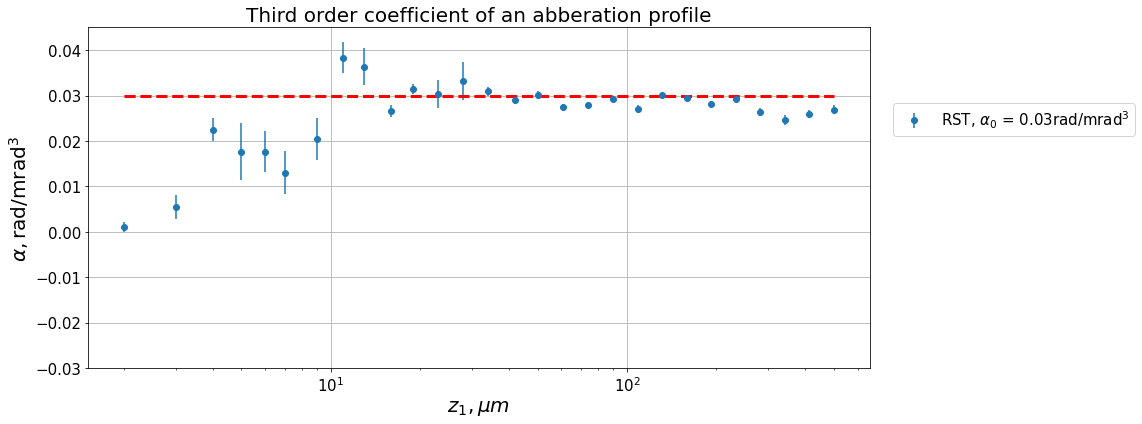

In [145]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16, 6))
ax.errorbar(n_frames_arr, np.abs(alp), dalp, fmt='o',
            label=r'RST, $\alpha_0$ = ' + '{:.3}'.format(alp_0) + r'$\mathrm{rad} / \mathrm{mrad}^3$')
# ax.errorbar(n_frames_arr, np.abs(alp_st), dalp_st, fmt='o',
#             label=r'PXST, $\alpha$ = ' + '{:.3} '.format(alp_0) + r'$\mathrm{rad} / \mathrm{mrad}^3$')
ax.hlines(alp_0, n_frames_arr.min(), n_frames_arr.max(), linestyles='dashed', linewidth=3, colors='r')
ax.set_title(r'Third order coefficient of an aberration profile', fontsize=20)
ax.grid(True)
ax.set_xscale('log')
ax.set_xlabel(r'$z_1, \mu m$', fontsize=20)
ax.set_ylabel(r'$\alpha, \mathrm{rad} / \mathrm{mrad}^3$', fontsize=20)
ax.set_ylim(-np.min(alp_0), 1.5 * np.max(alp_0))
ax.legend(bbox_to_anchor=(1.02, 0.8), fontsize=15)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()

# Experimental results

In [108]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1100), 2165: (0, 1, 430, 1140),
            2188: (0, 1, 365, 1155), 2202: (0, 1, 275, 1100), 2274: (0, 1, 430, 1140), 2291: (0, 1, 430, 1140),
            2311: (0, 1, 440, 1220), 2312: (0, 1, 440, 1220), 2313: (0, 1, 430, 1220), 2557: (0, 1, 150, 1000)}
data_path = 'results/exp/Scan_{:d}.cxi'
scan_num = 2557

loader = rst.loader()
data = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num])

In [157]:
with h5py.File('results/exp/diatom.cxi', 'r') as cxi_file:
    print(cxi_file['/entry_1/data_1/data'].dtype)

int32


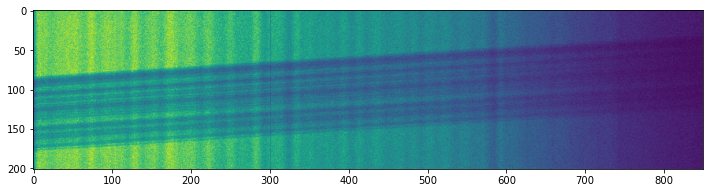

In [4]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

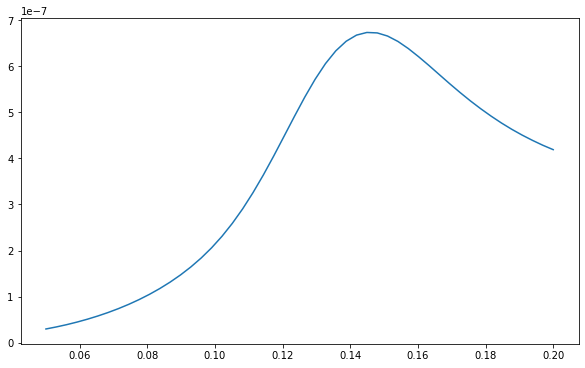

In [201]:
defoci = np.linspace(5e-5, 2e-4, 50)
ds_scan = data.defocus_sweep(defoci, ls_ri=30, return_sweep=False)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(defoci * 1e3, ds_scan)
plt.show()

In [302]:
data = data.update_defocus(defocus_fs=defoci[np.argmax(ds_scan)])

st_obj = data.get_st()

st_rgd = st_obj.iter_update_gd(ls_ri=15, ls_pm=2.5, sw_fs=6, n_iter=20, verbose=True)

Initial MSE = 0.030984, Initial ls_ri = 15.00
Iteration No. 1: Total MSE = 0.025798, ls_ri = 18.82
Iteration No. 2: Total MSE = 0.023825, ls_ri = 20.40
Iteration No. 3: Total MSE = 0.023105, ls_ri = 21.01
Iteration No. 4: Total MSE = 0.022989, ls_ri = 21.12
Iteration No. 5: Total MSE = 0.023005, ls_ri = 21.12


In [303]:
data = data.update_phase(st_rgd)
fit_obj = data.get_fit()

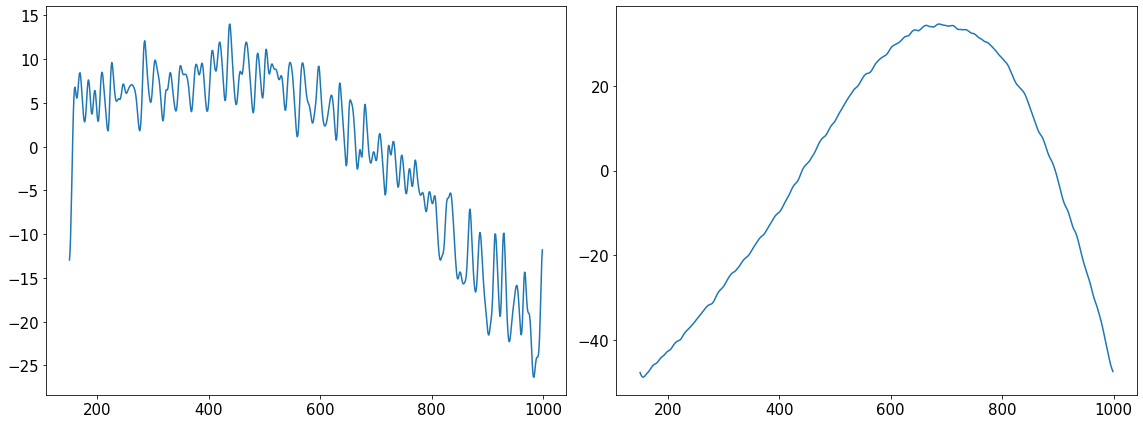

In [304]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_obj.get('pixels'), fit_obj.get('pixel_aberrations'))
axes[1].plot(fit_obj.get('pixels'), fit_obj.get('phase'))
for ax in axes:
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()

In [9]:
data_path = 'results/exp/scan_81763.cxi'
loader = rst.loader()
data_nsls = loader.load(data_path, roi=(0, 300, 200, 519))
data_nsls = data_nsls.update_mask(method='perc-bad', percentile=99.995)

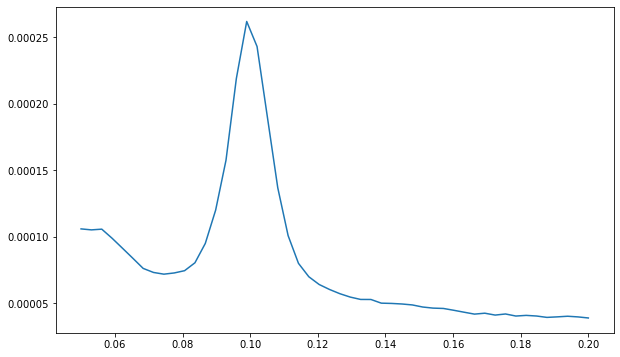

In [198]:
df_nsls = np.linspace(5e-5, 2e-4, 50)
dss_nsls = data_nsls.defocus_sweep(df_nsls, ls_ri=1.1, return_sweep=False)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(defoci * 1e3, ds_scan)
plt.show()

In [328]:
data.wavelength

array(7.09291753e-11)

In [295]:
data_nsls = data_nsls.update_defocus(defocus_fs=df_nsls[np.argmax(dss_nsls)])

st_obj_nsls = data_nsls.get_st()
st_obj_nsls = st_obj_nsls.update_reference(sw_ss=0, sw_fs=0, ls_ri=1.5)

st_rgd_nsls = st_obj_nsls.iter_update_gd(ls_ri=1.1, ls_pm=1.1, sw_fs=3, sw_ss=3, n_iter=20, verbose=True,
                                         learning_rate=0.1)

data_nsls = data_nsls.update_phase(st_rgd_nsls)

Initial MSE = 0.766755, Initial ls_ri = 1.10
Iteration No. 1: Total MSE = 0.553753, ls_ri = 1.30
Iteration No. 2: Total MSE = 0.445012, ls_ri = 1.41
Iteration No. 3: Total MSE = 0.389979, ls_ri = 1.49
Iteration No. 4: Total MSE = 0.433399, ls_ri = 1.47


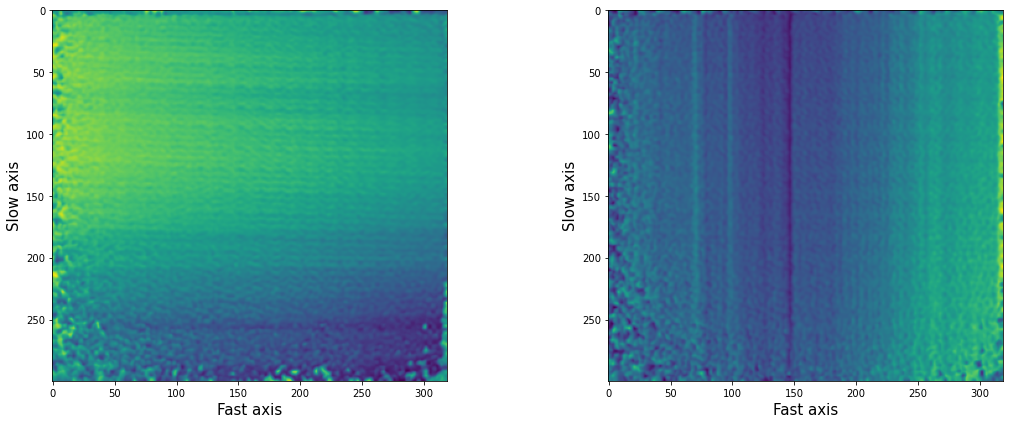

In [327]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0])
axes[1].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[1])
for ax in axes:
    ax.set_xlabel('Fast axis', fontsize=15)
    ax.set_ylabel('Slow axis', fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('nsls_pix_aberrations.pdf')

In [305]:
thetas = np.arange(10, 230) * data_nsls.y_pixel_size / data_nsls.distance
dev = np.interp(thetas, (fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
                   fit_obj.pixel_aberrations * data.defocus_fs * data.x_pixel_size / data.distance)

In [312]:
pix_shift = 5

# dev_ss = np.mean((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0, :, 100:], axis=1, keepdims=True)
dev_ss = (st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0, :, [280]].T
dev_fs = np.zeros(dev_ss.shape, dtype=np.float64)
d_ab = (dev - dev_ss[10 + pix_shift:230 + pix_shift, 0] * \
        data_nsls.defocus_ss * data_nsls.y_pixel_size / data_nsls.distance).mean()
dev_ss += d_ab / (data_nsls.defocus_ss * data_nsls.y_pixel_size / data_nsls.distance)

phase = ct_integrate(data_nsls.y_pixel_size**2 * dev_ss * data_nsls.defocus_ss / data_nsls.wavelength,
                     data_nsls.x_pixel_size**2 * dev_fs * data_nsls.defocus_fs / data_nsls.wavelength) \
        * 2 * np.pi / data_nsls.distance**2
fit_obj_nsls = rst.AberrationsFit(defocus=data_nsls.defocus_ss, distance=data_nsls.distance,
                                  phase=phase[:, 0], pixels=np.arange(0, phase.size) - pix_shift,
                                  pixel_aberrations=dev_ss[:, 0], pixel_size=data_nsls.y_pixel_size,
                                  roi=(0, phase.size), wavelength=data_nsls.wavelength)
dev_ss.shape

(300, 1)

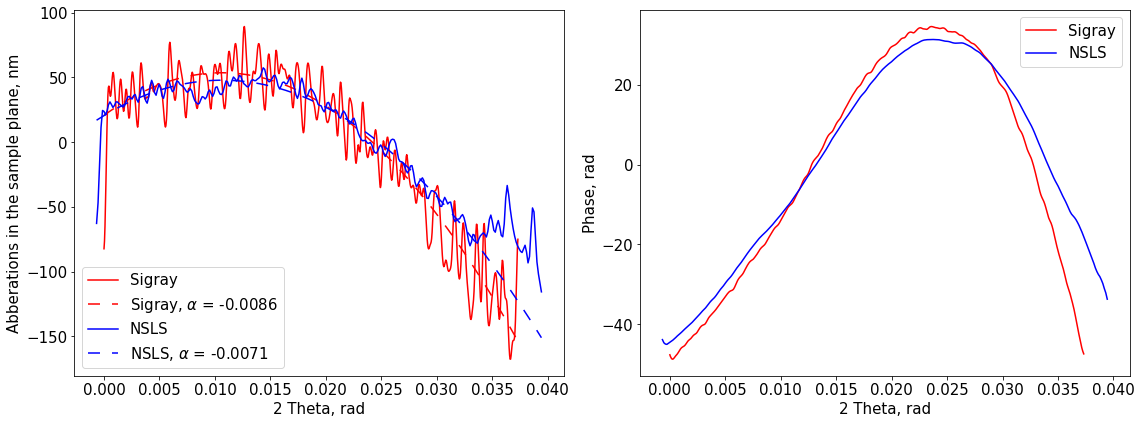

In [323]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fit_nsls = fit_obj_nsls.crop_data([10, 240]).fit()
fit = fit_obj.crop_data([10, 650]).fit(loss='linear')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.pixel_aberrations * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label='Sigray', c='r')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.model(fit['fit']) * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[0].set_ylabel('aberrations in the sample plane, nm', fontsize=15)
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.phase, label='Sigray', c='r')
axes[1].set_ylabel('Phase, rad', fontsize=15)
axes[0].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.pixel_aberrations * fit_obj_nsls.pix_ap * fit_obj_nsls.defocus * 1e9,
             label='NSLS', c='b')
axes[0].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.model(fit_nsls['fit']) * fit_obj_nsls.pix_ap * fit_obj_nsls.defocus * 1e9,
             label=r'NSLS, $\alpha$ = ' + '{:.4f}'.format(fit_nsls['alpha']),
             c='b', linestyle='dashed', dashes=(8, 8))
axes[1].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.phase, label='NSLS', c='b')
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
# plt.savefig('figures/nsls_sigray_comp.pdf')
plt.show()